Example of maximum-likelihood fit with iminuit version 2.
pdf is a mixture of Gaussian (signal) and exponential (background),
truncated in [xMin,xMax].
G. Cowan / RHUL Physics / December 2021

We first will start with importing all the necessary packages. The exercise is based on python implementation of Minuit package. We will use it to perform an unbinned MLE fit to the generated mass-spectrum with one peak. 

In [3]:
import numpy as np
import scipy.stats as stats
from scipy.stats import truncexpon #truncated exponential in [a,b]
from scipy.stats import truncnorm  #truncated normal distribution in [a,b]
from scipy.stats import chi2
import iminuit
from iminuit import Minuit
import matplotlib.pyplot as plt
from matplotlib import container
plt.rcParams["font.size"] = 14
print("iminuit version:", iminuit.__version__)  # need 2.x

iminuit version: 2.31.1


In [2]:
import mplhep as hep
hep.style.use("ROOT") # Or CMS, ATLAS, LHCb2...

ModuleNotFoundError: No module named 'mplhep'

Now, here we will upload the dataset generated for you beforehand. 

In [3]:
import pandas as pd

df = pd.read_csv("../datasets/dataset.csv", header=None)
xData = df.values  

# Task 0

Get familiar with the dataset. Can you already guess which models you will need to use to fit it? How many parameters you are going to estimate? Write a python function that takes as input on data `x` and parameters `par` and returns the pdf. 

<Axes: ylabel='Frequency'>

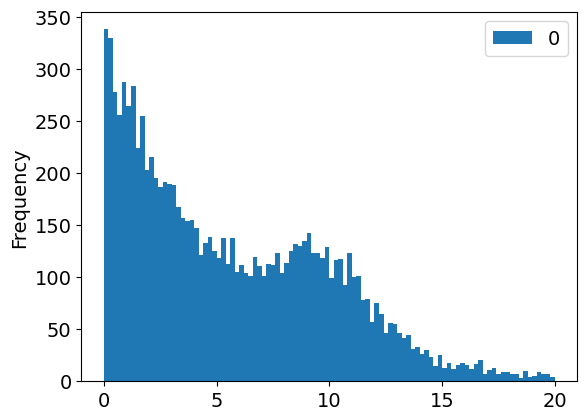

In [4]:
# Solution
df.plot.hist(bins=100)

In [ ]:
#Write your model here

<details>
<summary><strong>Click to show the solution</strong></summary>

Solution: The model we will use is rather simple. The signal is modelled with a single Gaussian, while the background is modelled with exponential. The total PDF is defined as following :
$$f(m) = \theta \cdot G(m; \mu, \sigma) + (1 - \theta)\cdot Exp(m; \xi)$$
where $\theta$ is signal fraction and $\xi$ is exponential power. 

```python
def f(x, par):
    theta   = par[0]
    mu      = par[1]
    sigma   = par[2]
    xi      = par[3]
    fs = stats.truncnorm.pdf(x, a=(xMin-mu)/sigma, b=(xMax-mu)/sigma, loc=mu, scale=sigma)
    fb = stats.truncexpon.pdf(x, b=(xMax-xMin)/xi, loc=xMin, scale=xi)
    return theta*fs + (1-theta)*fb
```
</details>  


We will now implement the nLL ourselves. Note, that Minuit expects the nLL python function to depend ONLY on the parameters. 

In [ ]:
def negLogL(par):
    pdf = f(xData, par)
    return -np.sum(np.log(pdf))

# Task 1 

Configure the iminuit fit. For this we need to setup the 2 POI $\theta$ and $\xi$ and 2 nuisance parameters $\mu$ and $\sigma$. 
1. We configure initial values
2. We configure initial step sizes for the parameter minimization.
3. We configure the limits, if necessary.

   

In [17]:
# Initialize Minuit and set up fit:
parin   = np.array([1, 1, 1, 1]) 
parname = ['theta', 'mu', 'sigma', 'xi'] #initial values
parstep = np.array([1000., 1000., 1000., 1000.])      # initial setp sizes 
parfix  = [False, False, False, False]       # change these to fix/free parameters
parlim  = [(None, None), (None, None), (None, None), (None, None)]    # set limits
  
# This was missing
xMin=0.
xMax=20.

m = Minuit(negLogL, parin, name=parname)
m.errors = parstep
m.fixed = parfix
m.limits = parlim
m.errordef = 0.5                          # errors from lnL = lnLmax - x

NameError: name 'negLogL' is not defined

<details>
<summary><strong>Click to show the solution</strong></summary>

```python
parin   = np.array([0.2, 10., 2., 5.])      # initial values 
parname = ['theta', 'mu', 'sigma', 'xi']
parname_latex = [r'$\theta$', r'$\mu$', r'$\sigma$', r'$\xi$']
parstep = np.array([0.1, 1., 1., 1.])           # initial setp sizes
parfix  = [False, True, True, False]            # change to fix/free param.
parlim  = [(0.,1), (None, None), (0., None), (0., None)]
```
</details> 

Now let's do the fit and get the covariance.

In [16]:
# Do the fit, get errors, extract results
m.migrad()                                        # minimize -logL
MLE = m.values                                    # max-likelihood estimates
sigmaMLE = m.errors                               # standard deviations
cov = m.covariance                                # covariance matrix
rho = m.covariance.correlation()                  # correlation coeffs.

NameError: name 'm' is not defined

Check the parameters values and standard deviation. 

In [ ]:
print(r"par index, name, estimate, standard deviation:")
for i in range(m.npar):
    if not m.fixed[i]:
        print("{:4d}".format(i), "{:<10s}".format(m.parameters[i]), " = ",
         "{:.6f}".format(MLE[i]), " +/- ", "{:.6f}".format(sigmaMLE[i]))

In [ ]:
print(r"free par indices, covariance, correlation coeff.:")
for i in range(m.npar):
    if not(m.fixed[i]):
        for j in range(m.npar):
            if not(m.fixed[j]):
                print(i, j, "{:.6f}".format(cov[i,j]), "{:.6f}".format(rho[i,j]))

Let's plot fitted data 

In [ ]:
# Plot fitted pdf
yMin = 0.
yMax = f(0., MLE)*1.1
fig = plt.figure(figsize=(8,6))
xCurve = np.linspace(xMin, xMax, 100)
yCurve = f(xCurve, MLE)
plt.plot(xCurve, yCurve, color='dodgerblue')
# Plot data as tick marks
tick_height = 0.05*(yMax - yMin)
x = np.asarray(xData).flatten()
xvals = np.vstack([x, x])
yvals = np.vstack([np.zeros_like(x), tick_height * np.ones_like(x)])
plt.plot(xvals, yvals, color='black', linewidth=1)
plt.xlabel(r'$x$')
plt.ylabel(r'$f(x; \theta)$')
plt.figtext(0.6, 0.8, r'$\hat{\theta} = $' + f'{MLE[0]:.4f}' +
            r'$\pm$' + f'{sigmaMLE[0]:.4f}')
plt.figtext(0.6, 0.72, r'$\hat{\xi} = $' + f'{MLE[3]:.4f}' +
            r'$\pm$' + f'{sigmaMLE[3]:.4f}')
plt.xlim(xMin, xMax)
plt.ylim(yMin, yMax)
plt.show()

Make a lnL profile plot 

In [ ]:
# Make scan of lnL (for theta, if free)
if not(m.fixed['theta']):
    plt.figure()
    m.draw_mnprofile('theta')
    plt.show()

Make a contour plot of $\ln L = \ln L_{max} - 1/2$ (here for $\theta$ and $\xi$).
The tangents to this contour give the standard deviations.

In [ ]:
Q_alpha = #your solution
ndof = #your solution 

CL = stats.chi2.cdf(Q_alpha, ndof)            
if not(m.fixed['theta'] | m.fixed['xi']):
    fig, ax = plt.subplots(1,1)
    con = m.mncontour('theta', 'xi', cl=CL, size=200)
    con = np.vstack([con, con[0]])         # close contour
    plt.plot(MLE[0], MLE[3], marker='o', linestyle='None', color='black', label=r'$(\hat{\theta}, \hat{\xi})$')
    plt.plot(con[:,0], con[:,1], color='black', linewidth=1)
    plt.xlabel(r'$\theta$', labelpad=5)
    plt.ylabel(r'$\xi$', labelpad=5)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.4, 0.93, r'$\ln L = \ln L_{\rm max} - 1/2$')
    plt.show()

Confidence region from $\ln L = \ln L_{max} - Q/2$ (here for $\theta$ and $\xi$)
where Q is the chi2 quantile of CL = 1-alpha = 0.683 and 0.95 for 2 dof.

if not(m.fixed['theta'] | m.fixed['xi']):
    fig, ax = plt.subplots(1,1)
    m.draw_mncontour('theta', 'xi', cl=[0.683, 0.95], size=200);
    plt.plot(MLE[0], MLE[3], marker='o', linestyle='None', color='black', label=r'$(\hat{\theta}, \hat{\xi})$')
    plt.xlabel(r'$\theta$', labelpad=10)
    plt.ylabel(r'$\xi$', labelpad=10)
    plt.subplots_adjust(left=0.2, right=0.9, top=0.9, bottom=0.2)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles, labels, loc='upper right', fontsize=14, frameon=False)
    plt.figtext(0.3, 0.93, r'$\ln L = \ln L_{\rm max} - \frac{1}{2} F^{-1}_{\chi^2}(1-\alpha;n)$')
    plt.show()

# Task 2


Now checkout `datasets/dataset[1-5].csv`. Repeat the fit for all of them and plot the change of the $\sigma(\theta)$ versus sample size. Which relation do you observe?

In [ ]:
#Add your code here


# Task 3

Often we have some idea of our parameter phases space even before we fit our data. For example, we might know that one of our nuisance parameters has been measured before with a certain uncertainty and we would like to use this prior knowledge to constrain it.   

For instance, let's assume we have a generic likelihood $\mathcal{L}$, that depends on the nuisance parameter $a$:
$$\mathcal{L} = \prod_{i}^{N} P(x_{i}| a)$$
However, the nuisance parameter $a$ is known to be constrained with PDF $R(a| a', \sigma_a)$. This modifies the likelihood and adds a constraint term to the expression: 
$$\mathcal{L} = \prod_{i}^{N} P(x_{i}| a) R(a| a', \sigma_a)$$.
Now this also modifies the NNL that we want to minimize. 

Now let's assume that instead of fixing the mass $\mu$ we actually include the information from the previous measurement which established $\mu$ to be $10.0 \pm 0.2$. Implement the Gaussian constraint to the negative likelihood function reflecting this prior and rerun the fit. 

Note: for the Gaussian constraint $\mu \sim G(\mu', \sigma_\mu)$, the NLL changes as : 
$$\text{NLL}_{constrained} = \text{NLL}_{unconstrained} + \frac{(\mu - \mu')^2}{2\sigma_\mu^2}$$

In [ ]:
#Here comes your solution
#def negLogL

<details>
<summary><strong>Click to show the solution</strong></summary>
    
```python
def negLogL(par):  
    mu      = par[1]
    pdf = f(xData, par)
    logL = np.sum(np.log(pdf))
    constraint = 0.5 * ((mu - 10.0) / 0.2) ** 2

    return -logL + constraint
```
</details>   
    

# Task 4

Commonly in flavour physics we use weights to simplify the final negLogL fit. Sometimes, the weights might be performing the statistical background subtraction, likesPlot weights or COWs. Sometimes, the weights can account for the detector and reconstruction effects, like efficiency weights. That way or another, the effect of weighting has to be accounted for in the likelihood. 

The likelihood where each data point is weighted by weight $w_{i}$ becomes : 
$$L_{weighted} = \prod_{i}^{N} P(x_{i}| \theta)^{w_{i}}$$
If one applies the standard definition of the $\theta$ uncertainties to such weighted likelihood : 
$$V_{\theta} = - \Big[\frac{\partial^2 L }{\partial \theta^2}\Big]\Big|_{\theta = \hat{\theta}}$$
the resulting uncertainty is *underestimated*.

This effect can be corrected in multiple ways. 

1. Introducing a scaling factor $\alpha$ to the likelihood [0905.0724](https://arxiv.org/abs/0905.0724):  
$\alpha = \frac{\sum^{N}_{i} w_{i}}{\sum_{i}^N w_i^2}$, such that the NLL corresponds to the $NLL = -\alpha \sum_i w_i ln P_{i} $. 

The RooFit users might recognize this as the the fit configuration options called `SumW2Errors(kFalse)`.

This will rescale the weights so that their sum corresponds to the effective sample size. 

2. Using square weighted Hessian matrix: 

$$V_{ij} = H_{ik}^{-1} W_{kl} H_{lj}^{-1}$$, 

where $H$ is a weighted Hessian matrix and $W$ is a squared weighted Hessian matrix defiend as : 
$$W_{kl} = - \sum_{i}^N w_i^2 \frac{\partial^2 L(x_i | \vec{\theta}) }{\partial \theta_i \partial \theta_j}$$

The RooFit users might recognize this as the fit configuration options called `SumW2Errors(kTrue)`.

3. A common method for estimating parameter uncertainties is bootstrapping. 
This involves repeatedly resampling the original dataset with replacement to generate new samples. 
Each resampled dataset is then used to refit the parameters. 
The standard deviation of these estimated values across all samples serves as an estimate of the parameter uncertainty. 
While this technique is broadly applicable and statistically sound, it typically requires solving numerically thousands of times, which can be computationally intensive. 

4. Asymptotic Errors

The weighted Hessian matrix method is in general not asymptotically correct for cases where 

$$E\Big(\sum_{e=1}^{N} w_e^2 \frac{\partial \ln L(x_e; \theta)}{\partial \theta_k} \frac{\partial \ln L(x_e; \theta)}{\partial \theta_l} |_{\hat{\lambda}} \Big) \neq -E \Big( \sum_{e=1}^{N} w_e^2  \frac{\partial^2 \ln L(x_e; \theta)}{\partial \theta_k \partial \theta_l} |_{\hat{\theta}} \Big)$$

The combat these cases, the AsymptoticErrors method is used [1911.01303](https://arxiv.org/pdf/1911.01303):

$$C_{ij} = \sum_{k,l=1}^{N_P} H^{-1}_{ik} D_{kl} H^{-1}_{lj} \Big|_{\hat{\theta}}
 $$

where $H^{-1}_{ik}$ is weighted Hessian and 
$$D_{kl} = \sum_{e=1}^{N} w_e^2 
\frac{\partial \ln P(x_e; \theta)}{\partial \theta_k}
\frac{\partial \ln P(x_e; \theta)}{\partial \theta_l}$$. 

Asymptotic method is currently the recommended default approach. 
It typically gives results very similar to those obtained by the bootstrapping. 

In the following example you will generate a decay time distribution with known true lifetime. However, it will be modified by the efficiency, modelled as 1-sigmoid. 

First, figure out what is the effect of the inefficeincy on the decay time distribution? How would you estimate its size? 



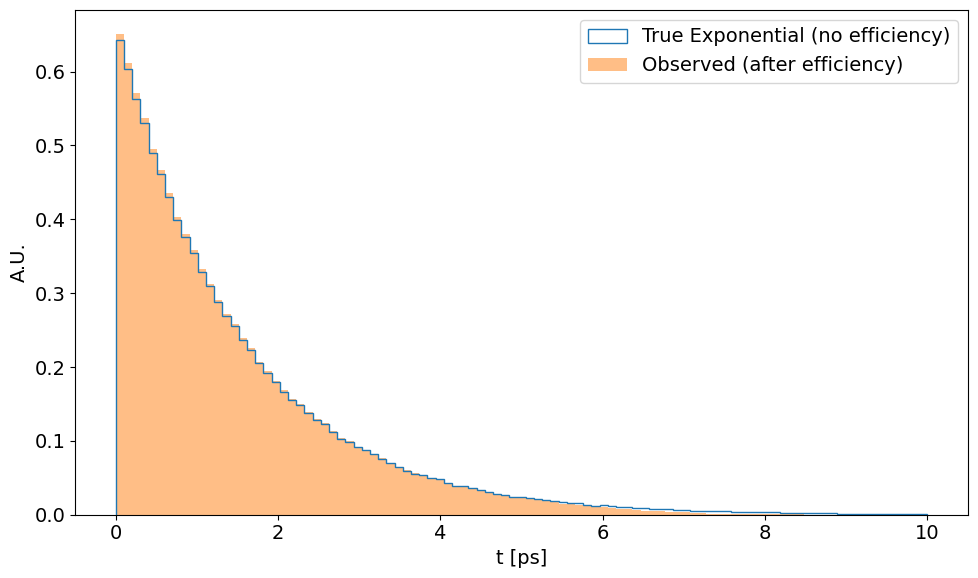

In [4]:
from scipy.special import expit  

np.random.seed(42)

#generate sample
n_samples = 500000                 
tau_true = 1.5                       
x = np.random.exponential(tau_true, n_samples) 

def efficiency(x, x0=7.0, k=0.7):
    return 1.0 - expit((x - x0) / k)

x_vals = np.linspace(0, 10, 1000)
eff_curve = efficiency(x_vals)

#apply eff
eff_values = efficiency(x)
accepted_mask = np.random.rand(n_samples) < eff_values
x_observed = x[accepted_mask]

bins = np.linspace(0, 10, 100)
plt.figure(figsize=(10, 6))
plt.hist(x, bins=bins, histtype='step', label='True Exponential (no efficiency)', density=True)
plt.hist(x_observed, bins=bins, histtype='stepfilled', alpha=0.5, label='Observed (after efficiency)', density=True)
x_vals = np.linspace(0, 10, 500)
plt.xlabel("t [ps]")
plt.ylabel("A.U.")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
#Here comes your definition of neglog_likelihood
#def neglog_likelihood

<details>
<summary><strong>Click to show the solution</strong></summary>
    
```python
def neglog_likelihood(tau):
    if tau <= 0:
        return 1e10 
    norm = 1 / tau * np.exp(-x_observed / tau)
    log_likelihood = np.log(norm)
    return -np.sum(log_likelihood)
```
</details>

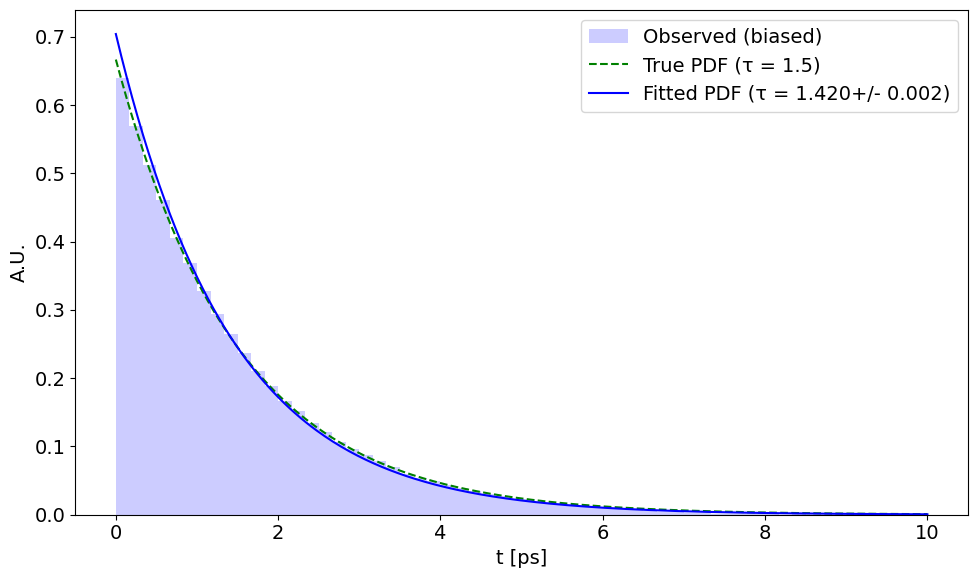

In [5]:
m = Minuit(neglog_likelihood, tau=1.0)
m.errordef = 0.5
m.migrad()

x_vals = np.linspace(0, 10, 300)
pdf_true = (1 / tau_true) * np.exp(-x_vals / tau_true)
pdf_fit = (1 / m.values['tau']) * np.exp(-x_vals / m.values['tau'])
plt.figure(figsize=(10, 6))
plt.hist(x_observed, bins=60, range=(0, 10), density=True, alpha=0.2, label='Observed (biased)', color='blue')
plt.plot(x_vals, pdf_true, 'g--', label=f'True PDF (τ = {tau_true})')
plt.plot(x_vals, pdf_fit, 'b-', label=f'Fitted PDF (τ = {m.values["tau"]:.3f}+/- {m.errors["tau"]:.3f})')
plt.xlabel("t [ps]")
plt.ylabel("A.U.")
plt.legend()
plt.tight_layout()
plt.show()

Now that you have observed the efficiency bias, it becomes obvious why one must accoutn for efficiency. In the next step derive the efficiency weights per event and check if the bias has dissapeared after minimixing the weighted likelihood. 

In [7]:
#Here define weights
weights = np.array()

TypeError: array() missing required argument 'object' (pos 0)

<details>
<summary><strong>Click to show the solution</strong></summary>
    
```python
weights = 1.0 / np.clip(efficiency(x_observed), 1e-3, 1.0) 
```
</details>

In [11]:
#Here define weighted likelihood
#def neglog_likelihood_weighted

<details>
<summary><strong>Click to show the solution</strong></summary>
    
```python
def neglog_likelihood_weighted(tau):
    if tau <= 0:
        return 1e10
    log_pdf = np.log((1 / tau) * np.exp(-x_observed / tau))
    return -np.sum(weights * log_pdf)
```
</details>

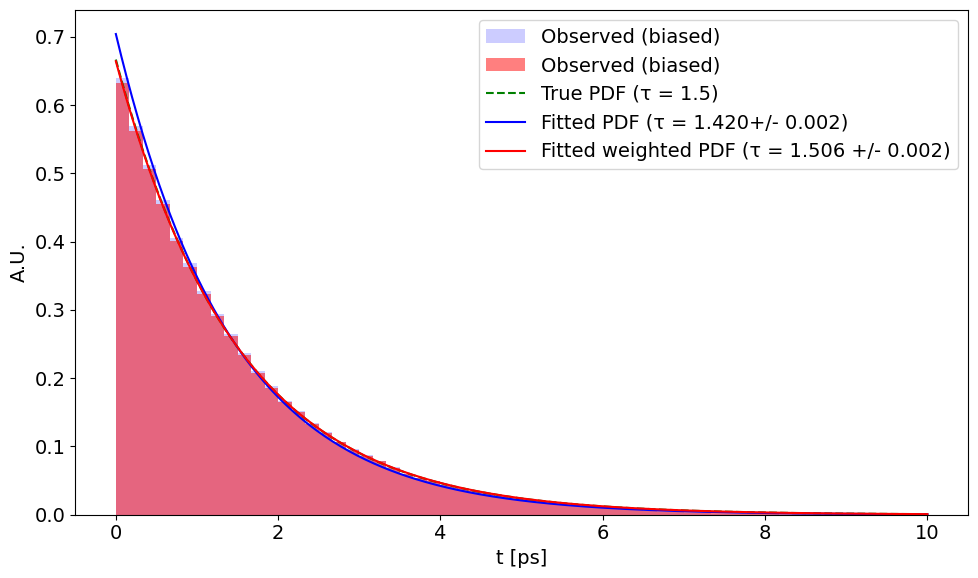

In [10]:
mw = Minuit(neglog_likelihood_weighted, tau=1.0)
mw.errordef = 0.5  
mw.migrad()
pdf_wfit = (1 / mw.values['tau']) * np.exp(-x_vals / mw.values['tau'])
plt.figure(figsize=(10, 6))
plt.hist(x_observed, bins=60, range=(0, 10), density=True, alpha=0.2, label='Observed (biased)', color='blue')
plt.hist(x_observed, bins=60, weights = weights, range=(0, 10), density=True, alpha=0.5, label='Observed (biased)', color='red')
plt.plot(x_vals, pdf_true, 'g--', label=f'True PDF (τ = {tau_true})')
plt.plot(x_vals, pdf_fit, 'b-', label=f'Fitted PDF (τ = {m.values["tau"]:.3f}+/- {m.errors["tau"]:.3f})')
plt.plot(x_vals, pdf_wfit, 'r-', label=f'Fitted weighted PDF (τ = {mw.values["tau"]:.3f} +/- {mw.errors["tau"]:.3f})')
plt.xlabel("t [ps]")
plt.ylabel("A.U.")
plt.legend()
plt.tight_layout()
plt.show()

Now compare different uncertainty estimations for the weighted likelihood fit with the baseline result you obtained in the previous step. Which uncertainty do you trust the most and why?

In [15]:
#1: alpha scaling 
def fit_with_alpha(x, w):
    sumw = np.sum(w)
    sumw2 = np.sum(w**2)
    alpha = sumw / sumw2

    def neglog_likelihood_scaled(tau):
        if tau <= 0:
            return 1e10
        log_pdf = np.log((1 / tau) * np.exp(-x / tau))
        return -alpha * np.sum(w * log_pdf)
      

    ms = Minuit(neglog_likelihood_scaled, tau=1.0)
    ms.errordef = 0.5
    ms.migrad()
    ms.hesse()
    return ms.values['tau'], ms.errors['tau']

In [16]:
#2: Weighted hessian
def fit_weighted_hessian(x, w):

    def second_derivatives(x, tau):
        return (1 / tau**2) - (2 * x / tau**3)

    def neglog_likelihood_weighted(tau):
        if tau <= 0:
            return 1e10
        log_pdf = np.log((1 / tau) * np.exp(-x / tau))
        return -np.sum(w * log_pdf)

    mhw = Minuit(neglog_likelihood_weighted, tau=1.0)
    mhw.errordef = 0.5
    mhw.migrad()
    mhw.hesse()

    H = np.sum(w * second_derivatives(x, mhw.values['tau']))
    W = -1*np.sum(w**2 * second_derivatives(x, mhw.values['tau']))
    V = (1 / H)**2 * W

    error_corrected = np.sqrt(V)
    return mhw.values['tau'], error_corrected

In [17]:
#3: bootstrap
def fit_bootstrap(x, w, n_bootstrap = 100):    
    x_fit = x
    w_fit = w
    def neglog_likelihood_weighted(tau):
        if tau <= 0:
            return 1e10
        log_pdf = np.log((1 / tau) * np.exp(-x_fit / tau))
        return -np.sum(w_fit * log_pdf)

    bootstrap_taus = []
    for _ in range(n_bootstrap):
        bootstrap_array = np.zeros(len(x))
        bootstrap_weight = np.zeros(len(w))
        indices = np.random.randint(0, len(x), size=len(x))
        x_fit = x[indices]
        w_fit = w[indices]


        m_bs = Minuit(neglog_likelihood_weighted, tau=1.0)
        m_bs.errordef = 0.5
        m_bs.migrad()

        if m_bs.valid:
            bootstrap_taus.append(m_bs.values["tau"])
        
        
    tau_bootstrap_mean = np.mean(bootstrap_taus)
    tau_bootstrap_std = np.std(bootstrap_taus)
    
    return tau_bootstrap_mean, tau_bootstrap_std

In [13]:
#4: asymptotic
def fit_asymptotic(x, w):

    def neglog_likelihood_weighted(tau):
        if tau <= 0:
            return 1e10
        log_pdf = np.log((1 / tau) * np.exp(-x / tau))
        return -np.sum(w * log_pdf)

    mas = Minuit(neglog_likelihood_weighted, tau=1.0)
    mas.errordef = 0.5
    mas.migrad()
    mas.hesse()
    def first_derivatives(x, tau):
        return -1 / tau + x / tau**2
    
    def second_derivatives(x, tau):
        return (1 / tau**2) - (2 * x / tau**3)

    D = np.sum(w**2 * first_derivatives(x, mas.values['tau'])**2 )
    H = np.sum(w * second_derivatives(x, mas.values['tau']))
    V = (1 / H)**2 * D
    error_corrected = np.sqrt(V)   
    return mas.values['tau'], error_corrected

In the last step throw multiple toys and compare the pulls between different types of uncertainty computation. 

Toys: 100%|██████████| 300/300 [00:15<00:00, 18.83it/s]


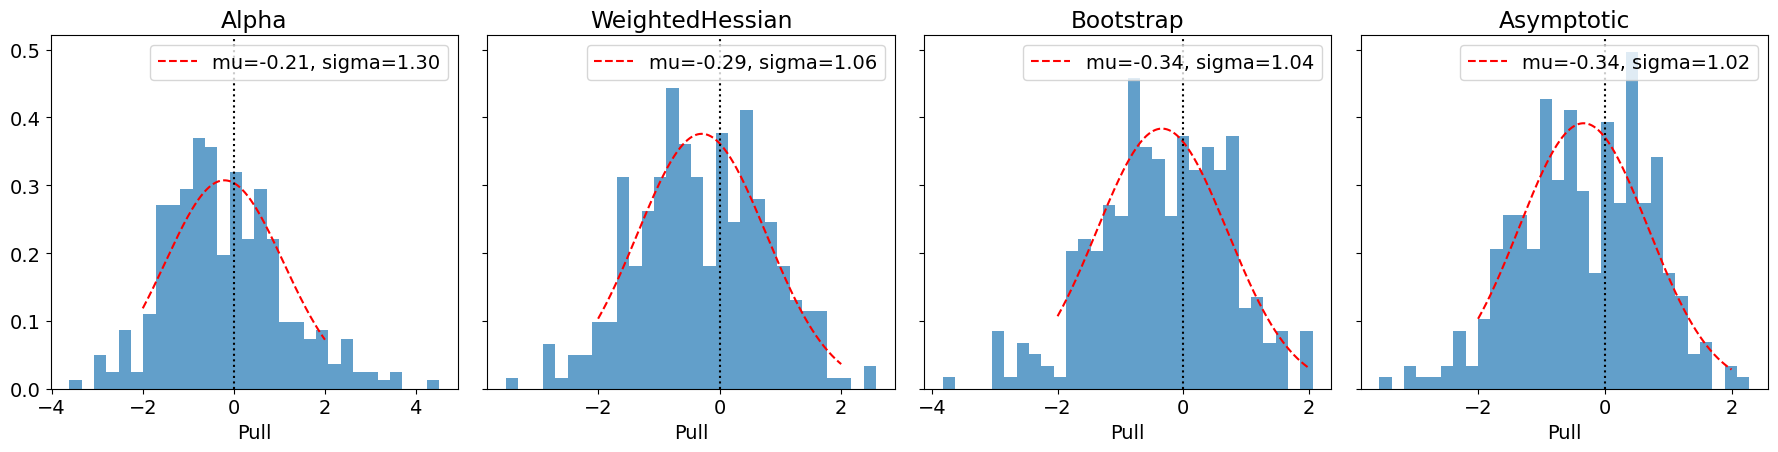

In [18]:
def pull(est, gen, err):
    return (est - gen) / err if err > 0 else 0.0

n_toys = 300
n_stats = 1000
tau_gen = 1.5
pulls_alpha, pulls_weighted_hessian, pulls_bootstrap, pulls_asymptotic = [], [], [], []

np.random.seed(42)

from tqdm import tqdm
for _ in tqdm(range(n_toys), desc="Toys"):
    x_true = np.random.exponential(tau_gen, n_stats)
    eff = efficiency(x_true)
    accept = np.random.rand(n_stats) < eff
    x_fit = x_true[accept]
    w_fit = 1.0 / np.clip(efficiency(x_fit), 1e-3, 1.0) 

    tau_a, err_a = fit_asymptotic(x_fit, w_fit)
    tau_d, err_d = fit_with_alpha(x_fit, w_fit)
    tau_s, err_s = fit_weighted_hessian(x_fit, w_fit)
    tau_b, err_b = fit_bootstrap(x_fit, w_fit)

    pulls_alpha.append(pull(tau_d, tau_gen, err_d))
    pulls_weighted_hessian.append(pull(tau_s, tau_gen, err_s))
    pulls_bootstrap.append(pull(tau_b, tau_gen, err_b))
    pulls_asymptotic.append(pull(tau_a, tau_gen, err_a))
    

fig, axs = plt.subplots(1, 4, figsize=(18, 5), sharey=True)
methods = ['Alpha', 'WeightedHessian', 'Bootstrap', 'Asymptotic']
pull_data = [pulls_alpha, pulls_weighted_hessian, pulls_bootstrap, pulls_asymptotic]

from scipy.stats import norm 

for i, (ax, pulls, label) in enumerate(zip(axs, pull_data, methods)):
    ax.hist(pulls, bins=30, density=True, alpha=0.7)
    mu, std = norm.fit(pulls)
    x_vals = np.linspace(-2, 2, 500)
    ax.plot(x_vals, norm.pdf(x_vals, mu, std), 'r--', label=f'mu={mu:.2f}, sigma={std:.2f}')
    ax.set_title(f'{label}')
    ax.set_xlabel('Pull')
    ax.axvline(0, color='black', linestyle=':')
    ax.legend()

fig.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Which uncertainty would you use in real analysis and why?

/*Your answer*/ 

**If you want to save your results please make sure to download the jupyter notebook!**